In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets, models
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def draw_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]
        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          solutions.drawing_styles.get_default_hand_landmarks_style(),
          solutions.drawing_styles.get_default_hand_connections_style())
        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN
        # Draw handedness (left or right hand) on the image.
        # cv2.putText(annotated_image, f"{handedness[0].category_name}",
        #             (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
        #             FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)
    return annotated_image

In [59]:
import cv2
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import torchvision.transforms as T


base_options = python.BaseOptions(model_asset_path='../gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)



def handGesture(img):
    landmarks = []
    errr = None
    # image = mp.Image.create_from_file(img)
    imgPil = T.ToPILImage()(img)
        
    medPil = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(imgPil))
    recognition_result = recognizer.recognize(medPil)
    hand_landmarks = recognition_result.hand_landmarks
    # markss = recognizer.detect(medPil)
    annotated_image = draw_landmarks_on_image(medPil, recognition_result)
    # annotated_image = 0
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr, annotated_image
    else:
        errr = 1
        return landmarks, errr, annotated_image



In [60]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets


class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.transform = transform
        self.featureExtraction = featureExtraction
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        if self.featureExtraction:
            feature, err, anot = self.featureExtraction(image)
            if (err != None):
                return self.__getitem__(idx + 1)
            else:
                custom_features = feature
        
        
        hasil = {
            'image': image,
            'labels': label,
            'id_class': idx,
            'custom_features': custom_features,
            'data': data
        }
        
        return hasil

In [61]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
     transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../asl_dataset", transform=train_transform, featureExtraction=handGesture)

print(type(dataset))

<class '__main__.dawtaset'>


IndexError: tuple index out of range

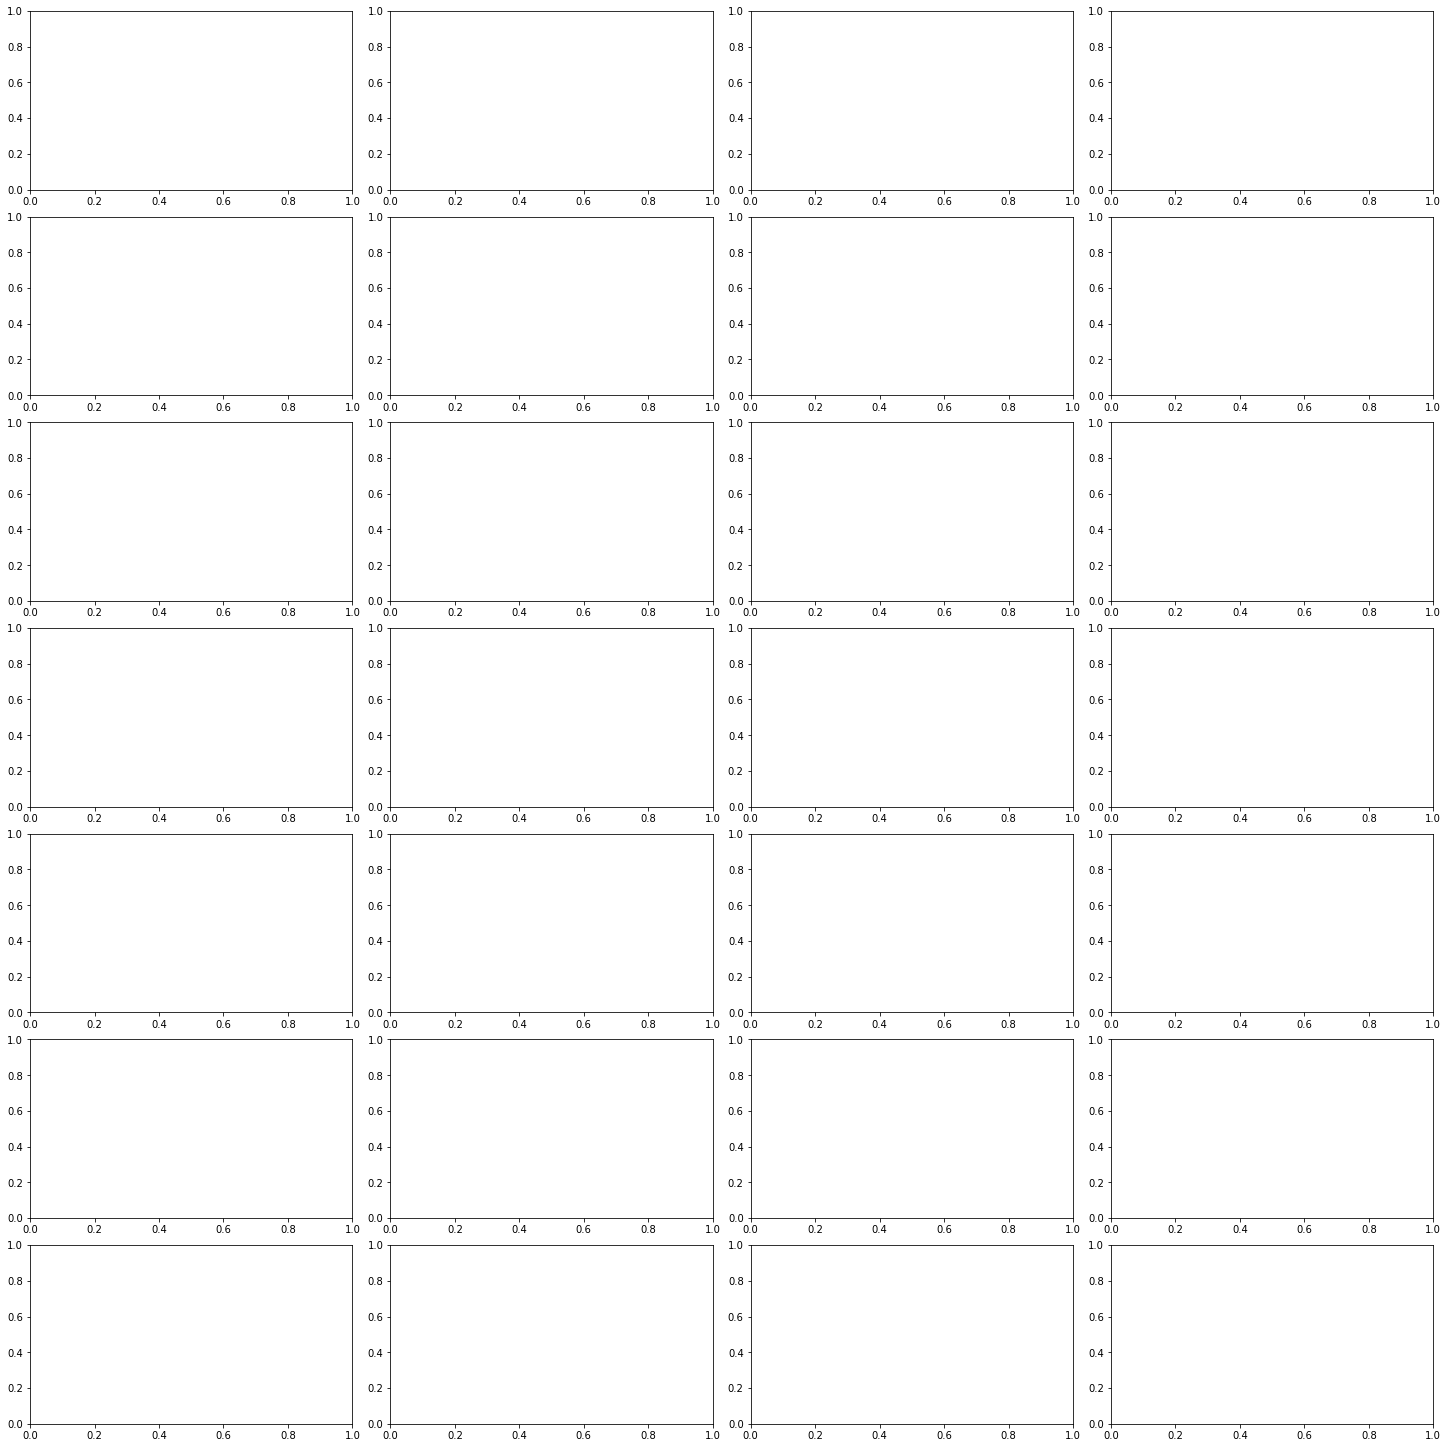

In [62]:
#Visualizing some examples in the training dataset X
from random import randrange
import torchvision.transforms as transforms

def detects(img):
    # imageT = train_transform(img)
    imageT = img.unsqueeze(0)
    # print(f"Image shape after: {image.shape}")
    imageT = imageT.to(device)
    datafitur, err = handGesture(img)
    datafitur = torch.as_tensor(datafitur).unsqueeze(0)
    datafitur = datafitur.to(device)
    # output = modelku(imageT, datafitur)
    max = torch.argmax(output)
    max = max.item()
    folderr = datasets.ImageFolder("../asl_dataset")
    # mapp = torch.unique(folderr.targets, return_counts=True)
    classdict = folderr.class_to_idx
    new_dict = {value: key for key, value in classdict.items()}
    return new_dict[max], datafitur


fig, ax = plt.subplots(nrows = 7, ncols = 4,  figsize = (20,20), constrained_layout = True)
fitur = {}
arrayofFitur = []

for y in range(7):
    for i in range(4):
        a = randrange(2000)
        hasil = dataset.__getitem__(a)
        # maping = transl(int(hasil["labels"]))
        # detek, datafitur = detects(hasil["image"])
        # detek = transl(int(detek))
        # _, _, anot = handGesture(hasil["image"])
        print(hasil)
        # ax[y,i].imshow(hasil["image"].T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
        # ax[y,i].imshow(anot.T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
        # ax[y,i].set_title(f'Actual Class: {maping}')
        # ax[y,i].set_xlabel(f'Prediction: {detek}')
        # datafitur = torch.squeeze(datafitur)
        # fitur = {'fitur':datafitur, 'class':maping}
        # arrayofFitur.append(fitur)
    

# ax[0,0].set_ylabel('Augmented Images',fontdict= {'fontsize':16})